In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.fft import fft2, ifft2

Data

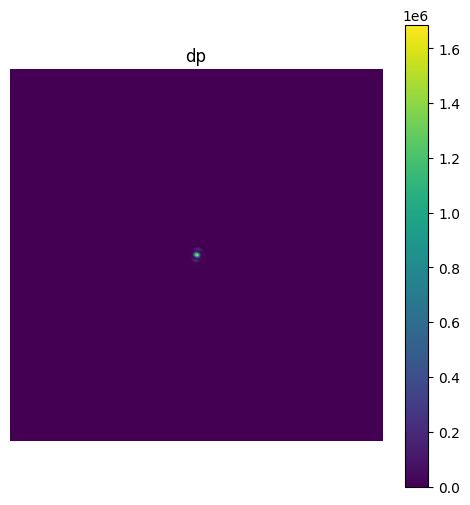

In [100]:
Y = np.load('dp.npy')

plt.figure(figsize=(6, 6))
plt.imshow(Y, cmap='viridis')
plt.title("dp")
plt.colorbar()
plt.axis('off')
plt.show()

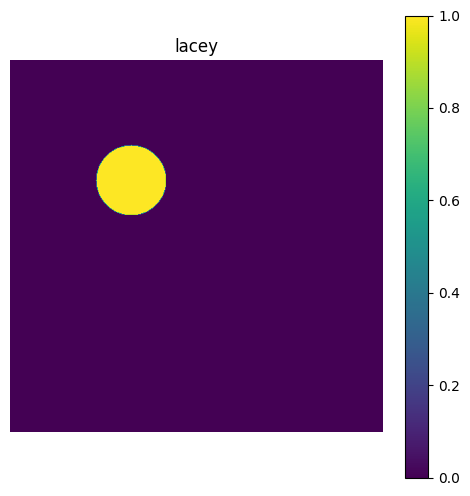

In [101]:
Y = np.load('lacey_supp.npy')

plt.figure(figsize=(6, 6))
plt.imshow(Y, cmap='viridis')
plt.title("lacey")
plt.colorbar()
plt.axis('off')
plt.show()

In [15]:
def visualize_reconstruction(x_hat, Y, epoch):
    x_vis  = torch.abs(x_hat).detach().cpu().squeeze().numpy()
    y_pred = torch.abs(torch.fft.fft2(x_hat)).detach().cpu().squeeze().numpy()
    y_meas = Y.detach().cpu().squeeze().numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(x_vis, cmap='gray')
    plt.title(f"|x̂|  (Epoch {epoch})")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(y_pred, cmap='viridis')
    plt.title("|F x̂|  (Predicted)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(y_meas, cmap='viridis')
    plt.title("Y  (Measured)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Simple DIP

In [6]:
# Define the forward observation model for phase retrieval
def forward_model(x):
    return torch.abs(torch.fft.fft2(x))

# Define the loss function
def loss_function(y, x_hat):
    return torch.nn.functional.mse_loss(y, forward_model(x_hat))

Epoch 0, Loss: 1205.14501953125


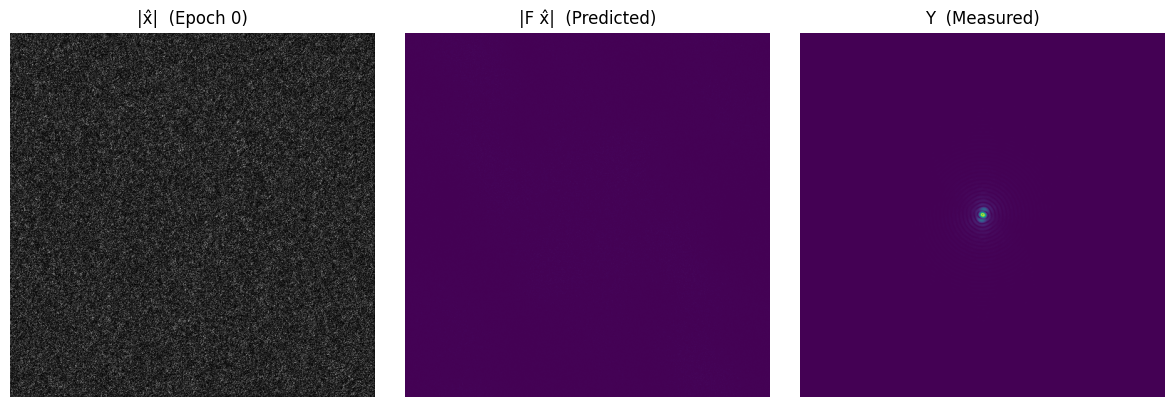

Epoch 10, Loss: 364.46624755859375
Epoch 20, Loss: 319.3281555175781
Epoch 30, Loss: 291.4127502441406
Epoch 40, Loss: 287.7499694824219
Epoch 50, Loss: 283.895263671875


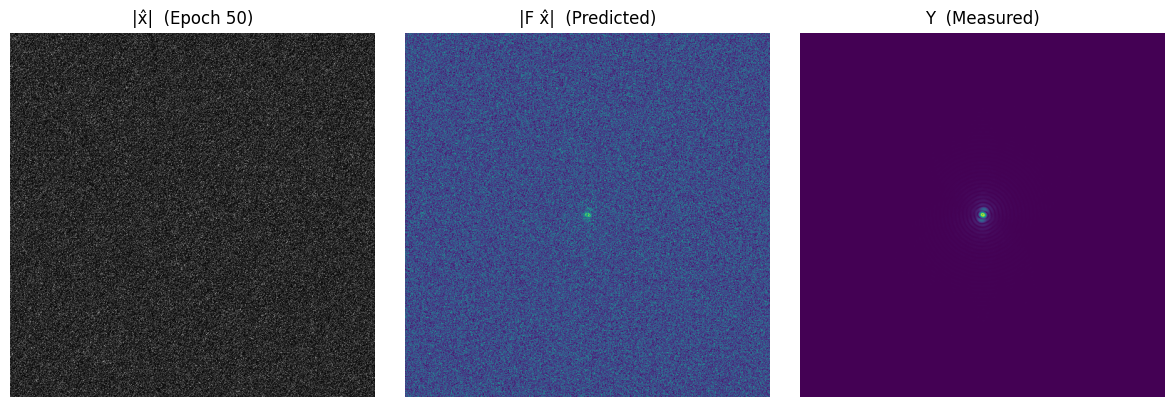

Epoch 60, Loss: 280.5903015136719
Epoch 70, Loss: 278.6077575683594
Epoch 80, Loss: 277.02606201171875
Epoch 90, Loss: 275.1091003417969
Epoch 100, Loss: 274.23565673828125


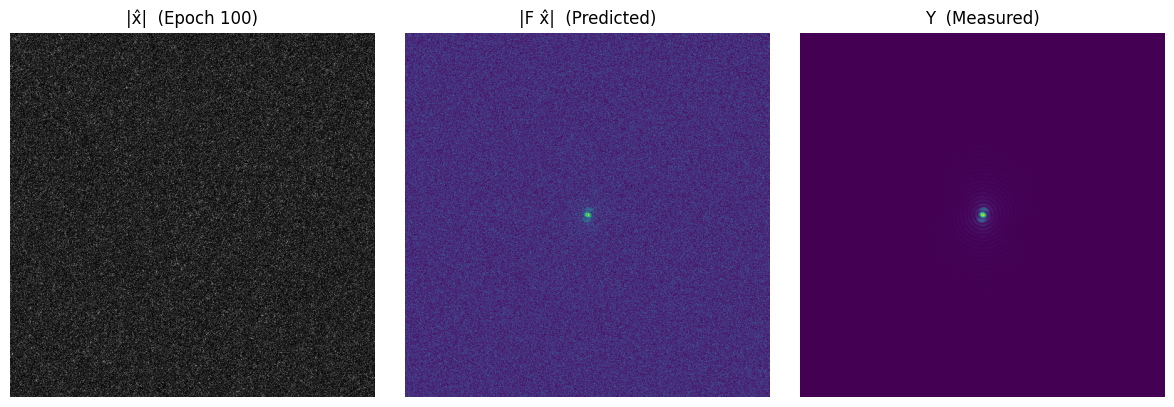

In [21]:
# Define DIP-style CNN
class DIPNet(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, hidden_dim=64):
        super(DIPNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, output_channels, 3, padding=1)
        )

    def forward(self, z):
        return self.net(z)

Y = np.load('dp.npy')
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  
sqrt_Y = torch.sqrt(Y)

# Initialize two DIP networks
G1 = DIPNet()  # magnitude
G2 = DIPNet()  # phase

# Fixed random seeds z1, z2
_, _, H, W = Y.shape
z1 = torch.randn(1, 1, H, W, requires_grad=False)
z2 = torch.randn(1, 1, H, W, requires_grad=False)

# Optimizers for both networks
optimizer = optim.Adam([
    {'params': G1.parameters(), 'lr': 0.001},  # smaller LR for magnitude
    {'params': G2.parameters(), 'lr': 0.01}    # larger LR for phase
])

# Training loop
num_epochs = 101
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate magnitude and phase
    mag = G1(z1)
    phase = G2(z2)

    # Complex reconstruction: X_hat = mag * exp(i * phase)
    X_hat = mag * torch.exp(1j * phase)

    # Forward model: magnitude of Fourier transform
    FX_hat = torch.fft.fft2(X_hat)
    abs_FX_hat = torch.abs(FX_hat)

    # Loss: match sqrt(Y) and |F(X_hat)|
    loss = torch.nn.functional.mse_loss(abs_FX_hat, sqrt_Y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
    if epoch % 50 == 0:
        visualize_reconstruction(X_hat, sqrt_Y, epoch)

Epoch 0, Loss: 2787.563720703125


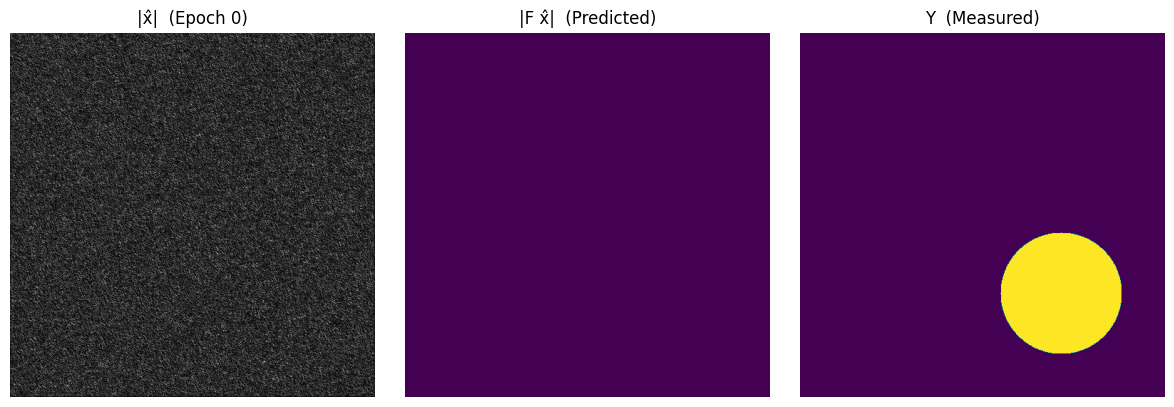

Epoch 10, Loss: 533.5623779296875
Epoch 20, Loss: 124.48656463623047
Epoch 30, Loss: 83.708740234375
Epoch 40, Loss: 40.123085021972656
Epoch 50, Loss: 31.490217208862305


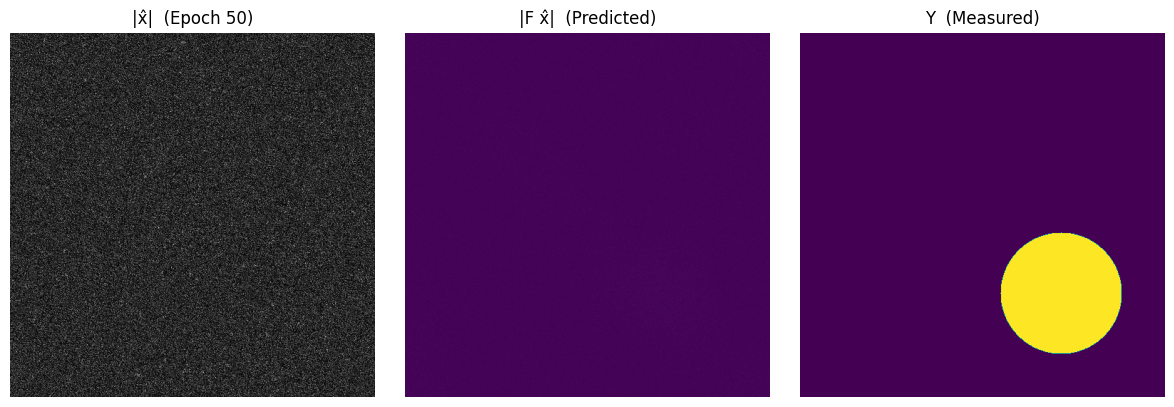

Epoch 60, Loss: 26.7260684967041
Epoch 70, Loss: 22.078086853027344
Epoch 80, Loss: 18.99012565612793
Epoch 90, Loss: 16.726024627685547
Epoch 100, Loss: 14.776578903198242


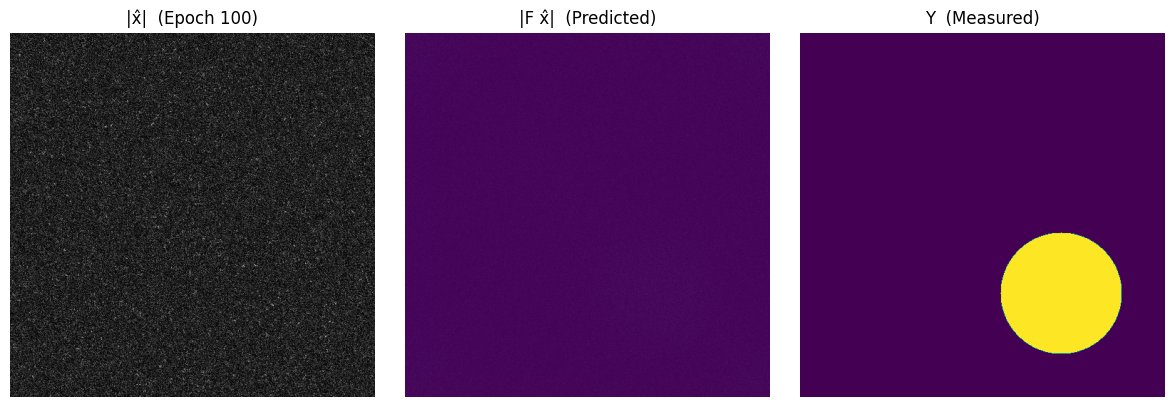

In [20]:
# Define DIP-style CNN
class DIPNet(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, hidden_dim=64):
        super(DIPNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, output_channels, 3, padding=1)
        )

    def forward(self, z):
        return self.net(z)

Y = np.load('cell_supp.npy')
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  
sqrt_Y = torch.sqrt(Y)

# Initialize two DIP networks
G1 = DIPNet()  # magnitude
G2 = DIPNet()  # phase

# Fixed random seeds z1, z2
_, _, H, W = Y.shape
z1 = torch.randn(1, 1, H, W, requires_grad=False)
z2 = torch.randn(1, 1, H, W, requires_grad=False)

# Optimizers for both networks
optimizer = optim.Adam([
    {'params': G1.parameters(), 'lr': 0.001},  # smaller LR for magnitude
    {'params': G2.parameters(), 'lr': 0.01}    # larger LR for phase
])

# Training loop
num_epochs = 101
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate magnitude and phase
    mag = G1(z1)
    phase = G2(z2)

    # Complex reconstruction: X_hat = mag * exp(i * phase)
    X_hat = mag * torch.exp(1j * phase)

    # Forward model: magnitude of Fourier transform
    FX_hat = torch.fft.fft2(X_hat)
    abs_FX_hat = torch.abs(FX_hat)

    # Loss: match sqrt(Y) and |F(X_hat)|
    loss = torch.nn.functional.mse_loss(abs_FX_hat, sqrt_Y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
    if epoch % 50 == 0:
        visualize_reconstruction(X_hat, sqrt_Y, epoch)